### MRI BRAIN TUMOR SEGMENTATION CLASSIFIER Modoling Process 



#### Import packages

In [442]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os, shutil
import numpy as np
from math import ceil
import itertools
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score
from skimage.feature import hog
from skimage import exposure
np.random.seed(123)

import keras
from keras import models
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from skimage.segmentation import mark_boundaries


%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in Image Data with datagenorator

In [2]:
directory = 'mri_data'
train_directory = 'mri_data/Training'
test_directory = 'mri_data/Testing'

In [3]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2870, 
        seed = 123)

# separate images from labels
train_images, train_labels = next(data_train)
print('Found Classes: ',data_train.class_indices)

Found 2870 images belonging to 4 classes.
Found Classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


### Create validation set for modeling process

Split the train dataset by 20% to create a validation dataset.  The validation set contained 1023 images and the new train dataset contained 4098 images.  I also used the imagedatagenorator to read in the test set which was presplit when downloaded from kaggle.  

Each new dataset was split to seperate the images from there lables to create the x(images) and y(labels) variables for the modeling process. 

In [213]:
data_genorator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

data_train= data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 4098, 
        seed = 123)

data_valid = data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'validation',
        target_size=(224, 224), 
        batch_size = 1023, 
        seed = 123)

data_test= ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

valid_images, valid_labels = next(data_valid)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


### Image Augmentation to fix class imbalance

Used imagedatagenorator to horizontil flip no tumor images and concatenate them into the no tumor class train image dataset balancing the number of images between the classes.


In [368]:
hflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

no_tumor_aug = hflip.flow_from_directory(train_directory,
                                        target_size=(224,224),
                                        batch_size = 395,
                                        seed = 123,
                                        classes= ['no_tumor'])



no_tumor_images_aug, no_tumor_images_labels = next(no_tumor_aug)

concat_notumor_images = np.vstack(no_tumor_images_aug)
concat_notumor_labels = np.array([[0.,0.,1.,0.] for i in range(len(no_tumor_images))])

train_images_aug = np.concatenate((train_images,no_tumor_images_aug))
train_labels_aug = np.concatenate((train_labels,concat_notumor_labels))

Found 395 images belonging to 1 classes.


### Brightness augmentation
For visual analysis of tumors, the hyperintensity of a tumor is a key feature when diagnosing the tumor.  To enhance tumor detection in my classifying model, I created an brightness augmented dataset with a range of images brightned up to 60% from their original intensity.  This augmented dataset was concatenated to the original train dataset to double the amount of images and include the brightned augmented images for modeling.  

In [241]:
bright = ImageDataGenerator(rescale=1./255,brightness_range=(1.0,1.6))

train_bright = bright.flow_from_directory(train_directory,
                                        target_size=(224,224),
                                        batch_size = 2297,
                                        seed = 123,
                                        classes = ['no_tumor','glioma_tumor','meningioma_tumor','pituitary_tumor'])
train_bright_images, train_bright_labels = next(train_bright)



print('Found Classes: ',train_bright.class_indices)

Found 2870 images belonging to 4 classes.
Found Classes:  {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}


In [249]:
train_total_bright_images = np.concatenate((train_images,train_bright_images))
train_total_bright_labels = np.concatenate((train_labels,train_bright_labels))

### Function for confusion matrix evaluation of CNN

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###  Baseline simple CNN
simple cnn with two convolutional layers with a 3x3 filter and maxpooling.  One dense layer with 32 neurons and an activation layer with softmax for catagorical classification.  The learning rate is set with the Adam optimizer, and I included an early stop to miniter validation loss with a patience of 5.  

In [44]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_baseline = cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2986016   
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

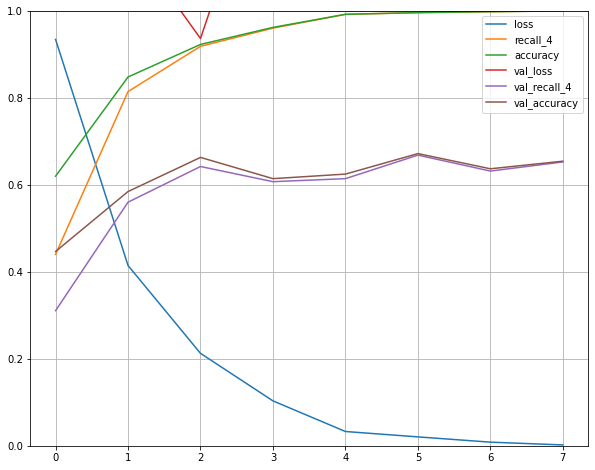

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Normalized confusion matrix
[[0.17       0.34       0.4        0.09      ]
 [0.         0.99130435 0.00869565 0.        ]
 [0.         0.03809524 0.95238095 0.00952381]
 [0.01351351 0.47297297 0.12162162 0.39189189]]


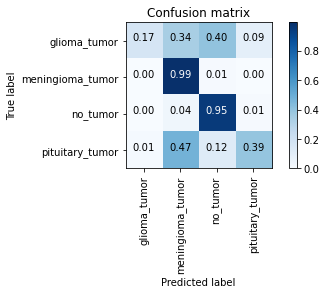

In [47]:
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The Model had had an accuracy of 65.9% and a recall of 65.9% on the hold out test data.  When looking at the confusion matrix, the simple CNN with no changes to the original dataset preformed exeptionally well at predicting menigioma and no tumor classes.  However, glioma tumors and pituitary tumors had very low true positive predictions.  Glioma tumers where primarily classified as no tumors or menigiomas, while pituitary tumors where predicted for the majority as menigioma tumors.  

For the simple model CNN, I am interested to see how the fixed class imbalance dataset and brigthened dataset affect the classification metrics.  

### baseline with class imbalance augmented dataset

Using the same architecture from above, I will see how fixing class imbalance effects the accuracy and recall of the classification model.  

In [48]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_basline_aug = cnn.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2986016   
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

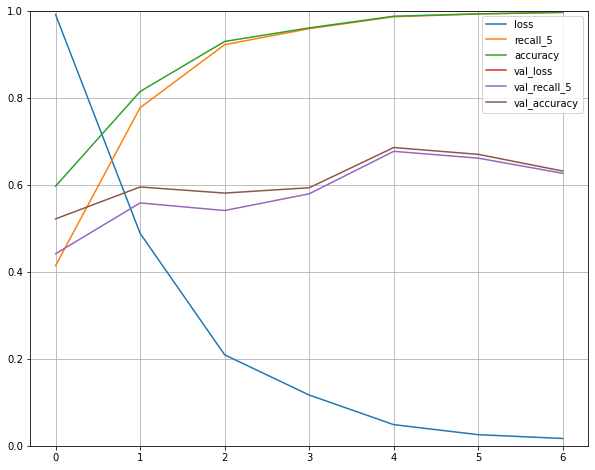

Normalized confusion matrix
[[0.17       0.18       0.61       0.04      ]
 [0.         0.95652174 0.04347826 0.        ]
 [0.         0.02857143 0.97142857 0.        ]
 [0.01351351 0.28378378 0.2972973  0.40540541]]


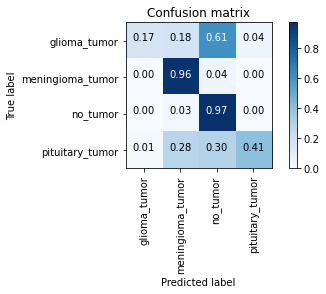

In [50]:
history_baseline_df = pd.DataFrame(history_basline_aug.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The fixed class imbalance dataset preformed similarly to the unaltered dataset.  Glioma tumors for this dataset where classified for the most part as no tumor.

### Bright adjust basic CNN
The same CNN with the bright adjusted dataset.

In [250]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn_bright = models.Sequential()
cnn_bright.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn_bright.add(layers.MaxPooling2D((2, 2)))
cnn_bright.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn_bright.add(layers.MaxPooling2D((2, 2)))
cnn_bright.add(layers.Flatten())
cnn_bright.add(layers.Dense(32, activation='relu'))
cnn_bright.add(layers.Dense(4, activation='softmax'))

cnn_bright.summary()

cnn_bright.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_basline_bright = cnn_bright.fit(train_total_bright_images, train_total_bright_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn_bright.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_303 (Conv2D)          (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_226 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_227 (MaxPoolin (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 93312)             0         
_________________________________________________________________
dense_169 (Dense)            (None, 32)                2986016   
_________________________________________________________________
dense_170 (Dense)            (None, 4)               

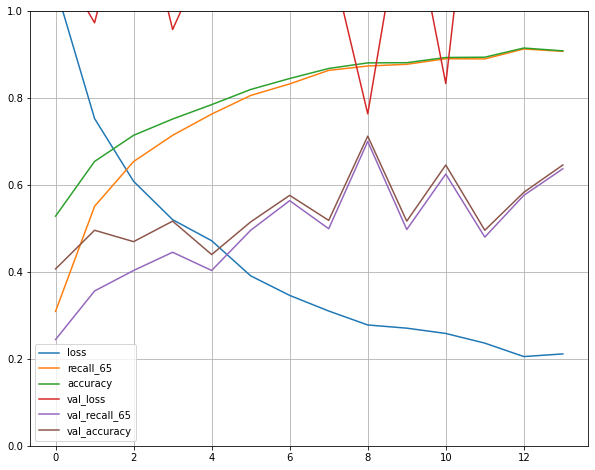

Normalized confusion matrix
[[0.32       0.16       0.45       0.07      ]
 [0.         0.76521739 0.22608696 0.00869565]
 [0.05714286 0.01904762 0.92380952 0.        ]
 [0.         0.2027027  0.05405405 0.74324324]]


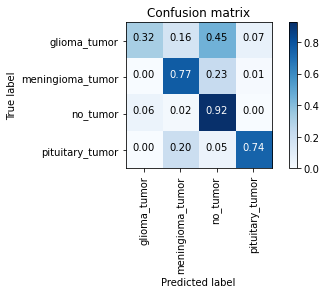

In [251]:
history_baseline_df = pd.DataFrame(history_basline_bright.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn_bright.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The brightened dataset had an accuracy of 69% and a recall of 68%.  The classification of pituitary tumors was greatly improved from the two previous models.  There is marginal improvment in the true positive classification of gliomas.  A more complex model might work better at detecting the distinct feature differences for gliomas and help improve the overall accuarcy and recall.  

### experimental CNN #1
3 convolutinal layers with batch normilization and max pooling for the first layer and average pooling in the subsequent layes.  Layer filters descend from 16X16 to 8X8 to 3X3.  Two dense layers of 1032 neurons and an activation output layer with softmax for classification of the 4 classes.

I chose a larger initial filter size for the first convolutional layer to catch any larger features that a smaller filter might miss.  I also included average pooling to see if the smoothing of pixels was more effective than the selection of the brightest pixels.
***
I compared the original dataset, fixed class imbalance dataset and the brightned dataset to see how the experimental CNN classified the tumor types.

In [106]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
exp1_cnn = models.Sequential()
exp1_cnn.add(layers.Conv2D(64, (16, 16), activation='relu', input_shape=(224, 224,  3),use_bias=True))
exp1_cnn.add(keras.layers.BatchNormalization())
exp1_cnn.add(layers.MaxPooling2D((2, 2)))
exp1_cnn.add(layers.Conv2D(64, (8, 8), activation='relu', input_shape=(224, 224,  3),use_bias=True))
exp1_cnn.add(keras.layers.BatchNormalization())
exp1_cnn.add(layers.AveragePooling2D((2, 2)))
exp1_cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
exp1_cnn.add(keras.layers.BatchNormalization())
exp1_cnn.add(layers.AveragePooling2D((2, 2)))
exp1_cnn.add(layers.Flatten())
exp1_cnn.add(layers.Dense(1032, activation='relu'))
exp1_cnn.add(layers.Dense(1032, activation='relu'))
exp1_cnn.add(layers.Dense(4, activation='softmax'))

exp1_cnn.summary()

exp1_cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_exp1_cnn = exp1_cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = exp1_cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 209, 209, 64)      49216     
_________________________________________________________________
batch_normalization_30 (Batc (None, 209, 209, 64)      256       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 104, 104, 64)      0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 97, 97, 64)        262208    
_________________________________________________________________
batch_normalization_31 (Batc (None, 97, 97, 64)        256       
_________________________________________________________________
average_pooling2d_3 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 46, 46, 32)      

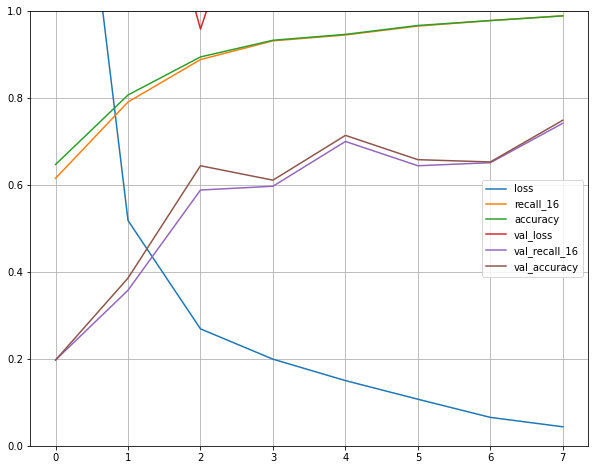

Normalized confusion matrix
[[0.2        0.21       0.38       0.21      ]
 [0.00869565 0.92173913 0.0173913  0.05217391]
 [0.01904762 0.02857143 0.94285714 0.00952381]
 [0.13513514 0.05405405 0.12162162 0.68918919]]


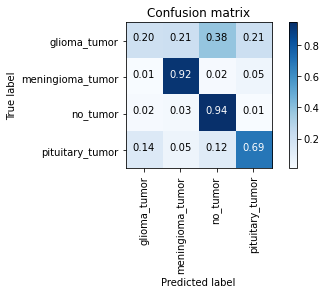

In [108]:
history_baseline_df = pd.DataFrame(history_exp1_cnn.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = exp1_cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

With an accuarcy of 70% and a recall of 69% this first experimental CNN marginally improved from the simple CNN above.  The number of pituitary true positives doubled for this dataset.  Glioma tumor classification however did not improve.  

### exp1 cnn with classimbalance aug dataset

In [122]:
batch_size = 50
num_classes = 4
epochs = 30
#np.random.seed(15)

#model architecture
exp1_cnn = models.Sequential()
exp1_cnn.add(layers.Conv2D(64, (6, 6), activation='relu', input_shape=(224, 224,  3),use_bias=True, padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))
exp1_cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True,padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))
exp1_cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True,padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))
exp1_cnn.add(layers.Conv2D(32, (2, 2), activation='relu',use_bias=True,padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))

exp1_cnn.add(layers.Flatten())

exp1_cnn.add(layers.Dense(1032, activation='relu'))
exp1_cnn.add(Dropout(0.5))
exp1_cnn.add(layers.Dense(4, activation='softmax'))

exp1_cnn.summary()

exp1_cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy',patience=4,verbose=1,mode='max')


history_exp1_cnn = exp1_cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = exp1_cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 224, 224, 64)      6976      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 56, 56, 32)      

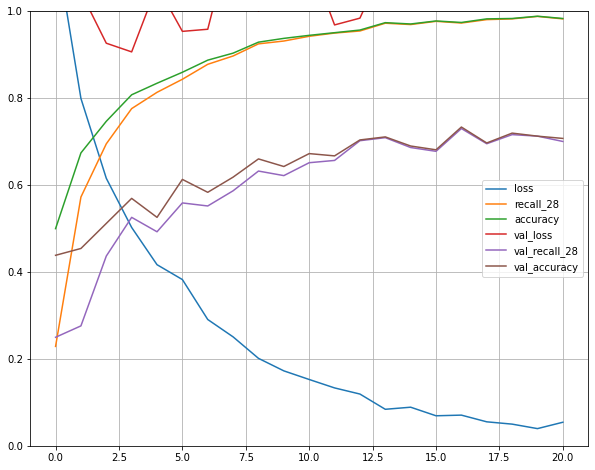

Normalized confusion matrix
[[0.18       0.18       0.6        0.04      ]
 [0.00869565 0.97391304 0.0173913  0.        ]
 [0.         0.04761905 0.95238095 0.        ]
 [0.02702703 0.37837838 0.12162162 0.47297297]]


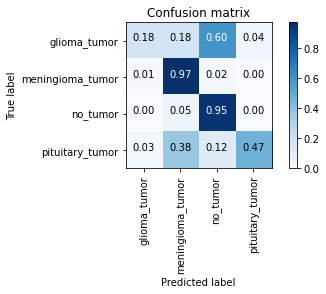

In [123]:
history_baseline_df = pd.DataFrame(history_exp1_cnn.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = exp1_cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The fixed class imbalance DataSet preformed worse than the unaltered dataset.  No notable changes from the simple CNN. 

### Experimental CNN 1 with Brightened Data

In [266]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
exp1_bright = models.Sequential()
exp1_bright.add(layers.Conv2D(64, (16, 16), activation='relu', input_shape=(224, 224,  3),use_bias=True))
exp1_bright.add(keras.layers.BatchNormalization())
exp1_bright.add(layers.MaxPooling2D((2, 2)))
exp1_bright.add(layers.Conv2D(64, (8, 8), activation='relu', input_shape=(224, 224,  3),use_bias=True))
exp1_bright.add(keras.layers.BatchNormalization())
exp1_bright.add(layers.AveragePooling2D((2, 2)))
exp1_bright.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
exp1_bright.add(keras.layers.BatchNormalization())
exp1_bright.add(layers.AveragePooling2D((2, 2)))
exp1_bright.add(layers.Flatten())
exp1_bright.add(layers.Dense(1032, activation='relu'))
exp1_bright.add(layers.Dense(1032, activation='relu'))
exp1_bright.add(layers.Dense(4, activation='softmax'))

exp1_bright.summary()

exp1_bright.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_exp1_bright = exp1_bright.fit(train_total_bright_images, train_total_bright_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = exp1_bright.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_338 (Conv2D)          (None, 209, 209, 64)      49216     
_________________________________________________________________
batch_normalization_70 (Batc (None, 209, 209, 64)      256       
_________________________________________________________________
max_pooling2d_259 (MaxPoolin (None, 104, 104, 64)      0         
_________________________________________________________________
conv2d_339 (Conv2D)          (None, 97, 97, 64)        262208    
_________________________________________________________________
batch_normalization_71 (Batc (None, 97, 97, 64)        256       
_________________________________________________________________
average_pooling2d_5 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_340 (Conv2D)          (None, 46, 46, 32)      

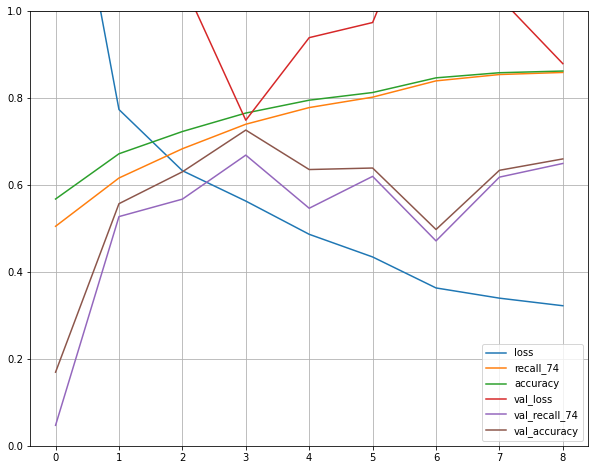

Normalized confusion matrix
[[0.28       0.36       0.27       0.09      ]
 [0.0173913  0.86086957 0.11304348 0.00869565]
 [0.2        0.00952381 0.78095238 0.00952381]
 [0.02702703 0.45945946 0.         0.51351351]]


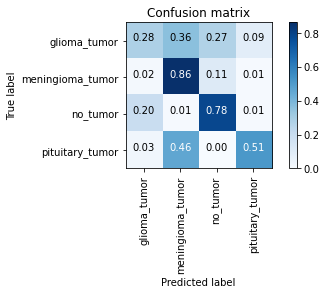

In [365]:
history_baseline_df = pd.DataFrame(history_exp1_bright.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = exp1_bright.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The brightened data had lower overall metrics with a significant drop in the true positives for no tumor.  Interstingly some no tumor classes are now being classified as glioma class.  Glioma classification has not improved for any dataset with this CNN architecture.  Looking at the learning curve for the brightned dataset, the model may be improved with stricter early stopping as there is a significant drop after the third epoch.

### AlexNet

For my next set of models I used the AlexNet architecture.  AlexNet is an award winning neural net that has 5 convolutional layerswith maxpooling and batch normilization.  The neural net also contains 2 dense layers with relu activation and 4096 neruons and an activation layer with softmax for multiclass activation.  I kept the same early stopping parameters for alexnet as I have had for the previous models.  

The AlexNet was ran with the three datasets to compare their efficiancy.  

In [124]:
batch_size = 24
num_classes = 4
epochs = 30
np.random.seed(7)


alex_no_aug = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex_no_aug.summary()

alex_no_aug.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_no_aug_history = alex_no_aug.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex_no_aug.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_48 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_49 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 12, 12, 384)     

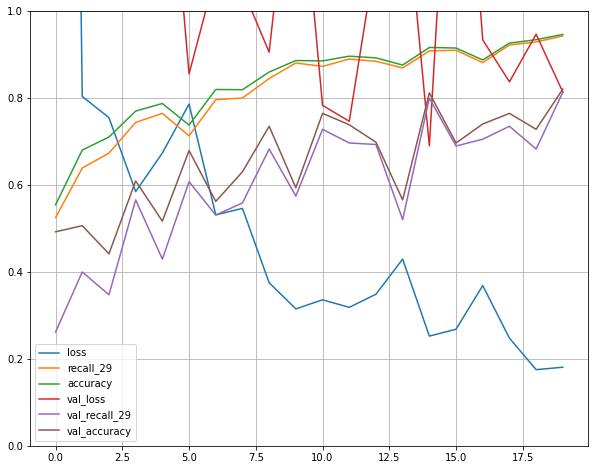

Normalized confusion matrix
[[0.2        0.3        0.4        0.1       ]
 [0.04347826 0.80869565 0.13043478 0.0173913 ]
 [0.02857143 0.00952381 0.96190476 0.        ]
 [0.04054054 0.31081081 0.31081081 0.33783784]]


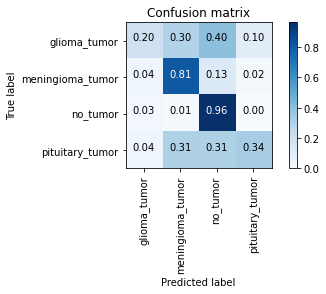

In [125]:
history_baseline_df = pd.DataFrame(alex_no_aug_history.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = alex_no_aug.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The AlexNet with the unaltered dataset underpreformed when compared to the previous two models with an overall drop in all true positive predictions. 

### AlexNet with class imbalance aug

In [127]:
batch_size = 24
num_classes = 4
epochs = 30



alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex.summary()

alex.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_history = alex.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_58 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_59 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 12, 12, 384)     

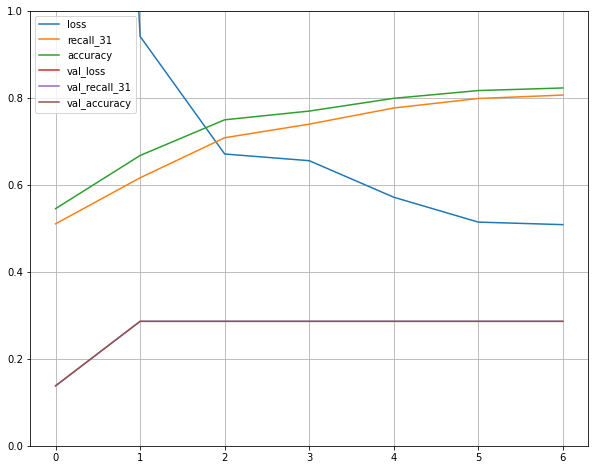

Normalized confusion matrix
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


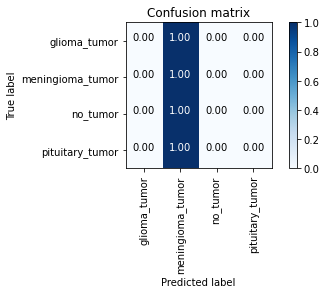

In [128]:
history_baseline_df = pd.DataFrame(alex_history.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = alex.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

This was by far the worst model so far.  The fixed class imbalance model predicted every image as a menigioma.

In [264]:
batch_size = 24
num_classes = 4
epochs = 30



alex_bright = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex_bright.summary()

alex_bright.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_bright_history = alex_bright.fit(train_total_bright_images, train_total_bright_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex_bright.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_333 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_65 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_256 (MaxPoolin (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_66 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_257 (MaxPoolin (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_335 (Conv2D)          (None, 12, 12, 384)     

Epoch 00028: early stopping
test loss: 1.1511614322662354
Test recall: 0.5989847779273987
Test Accuracy 0.6751269102096558


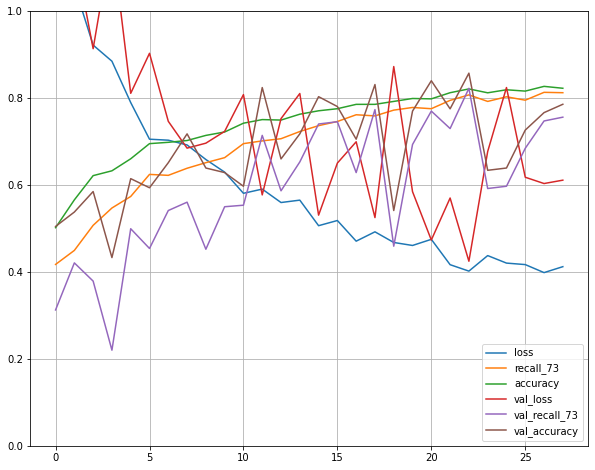

Normalized confusion matrix
[[0.33       0.16       0.4        0.11      ]
 [0.03478261 0.70434783 0.2        0.06086957]
 [0.0952381  0.03809524 0.86666667 0.        ]
 [0.         0.09459459 0.08108108 0.82432432]]


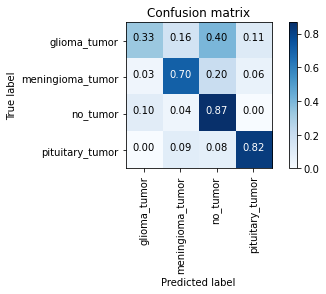

In [265]:
history_baseline_df = pd.DataFrame(alex_bright_history.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = alex_bright.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

The brightned dataset had lower overall accuracy and recall when compared to some of the earlier models.  However, the true positives for the pituitarty tumors where the highest so far in the modeling process.  Meningioma tumors saw a significant drop in true positives.  This may be a result of the brightness of the skull in the images interfering with the classification of these particular tumors which are situatied between the brain and the skull.  

### Experimental CNN 2 
4 convolutional layers all with maxppooling and dropout.  Filter size descends from 5X5 to two 3X3 and a final 2X2
two dense layers with 300 neurons and 50% dropout.  

For this CNN I wanted to increase the number of convolutional layers from the first experimental CNN.  I chose a smaller filter size and used dropout layers instead of batch normilization to reduce overfitting the model.

#### Experimental CNN 2 with original dataset

In [214]:
batch_size = 50
num_classes = 4
epochs = 40
#np.random.seed(8)

model_1 = models.Sequential()

model_1.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(3,3),strides=(2,2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(layers.Dropout(0.3))



model_1.add(layers.Flatten())


model_1.add(layers.Dense(300, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(300, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(4, activation='softmax'))

model_1.summary()

model_1.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=6,verbose=1,mode='auto')


history_exp2 = model_1.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = model_1.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_265 (Conv2D)          (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_184 (Dropout)        (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 111, 111, 128)     73856     
_________________________________________________________________
max_pooling2d_189 (MaxPoolin (None, 55, 55, 128)       0         
_________________________________________________________________
dropout_185 (Dropout)        (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_267 (Conv2D)          (None, 55, 55, 256)     

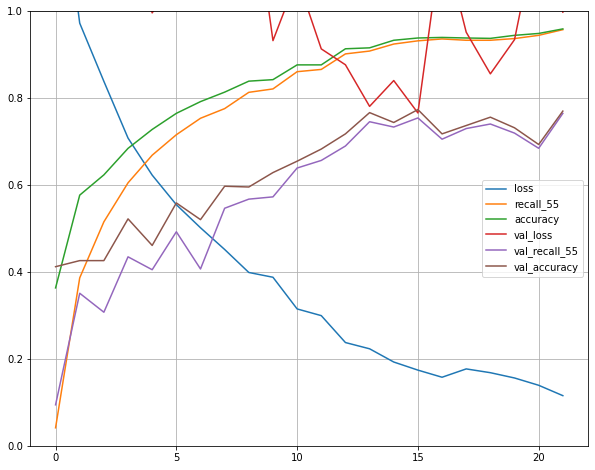

Normalized confusion matrix
[[0.18       0.3        0.47       0.05      ]
 [0.04347826 0.89565217 0.05217391 0.00869565]
 [0.02857143 0.03809524 0.93333333 0.        ]
 [0.02702703 0.33783784 0.14864865 0.48648649]]


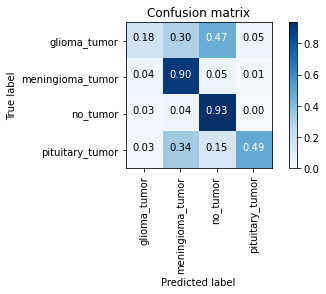

In [215]:
history_baseline_df = pd.DataFrame(history_exp2.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = model_1.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

No signifigant improvments for the unaltered dataset with experimental cnn 2.  Gliomas and pituitary tumors continue to be misclassified.  

#### Experimental CNN 2 with balanced dataset

In [239]:
batch_size = 50
num_classes = 4
epochs = 40
#np.random.seed(8)

model = models.Sequential()

model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(3,3),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.3))


model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='auto')


history_vgg16 = model.fit(train_aug_images, train_aug_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = model.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_297 (Conv2D)          (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_220 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_228 (Dropout)        (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 111, 111, 128)     73856     
_________________________________________________________________
max_pooling2d_221 (MaxPoolin (None, 55, 55, 128)       0         
_________________________________________________________________
dropout_229 (Dropout)        (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 55, 55, 256)     

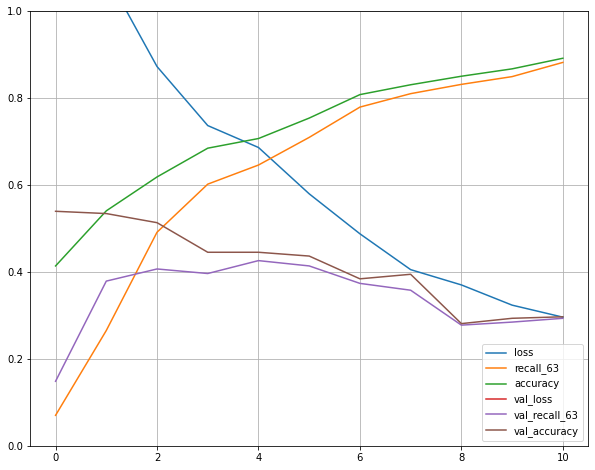

Normalized confusion matrix
[[0.54       0.17       0.22       0.07      ]
 [0.31304348 0.06086957 0.45217391 0.17391304]
 [0.9047619  0.00952381 0.08571429 0.        ]
 [0.08108108 0.05405405 0.13513514 0.72972973]]


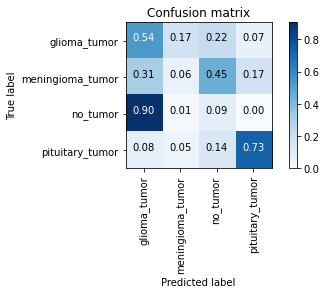

In [240]:
history_baseline_df = pd.DataFrame(history_vgg16.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = model.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

This model was massivley overfit with poor scores all around.  Interestingly thought the pituitary tumors had a high true positive rate.  

#### Experimental CNN 2 with brigthened data

In [262]:
batch_size = 50
num_classes = 4
epochs = 40
#np.random.seed(8)

model_bright = models.Sequential()

model_bright.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model_bright.add(layers.MaxPool2D(pool_size=(3,3),strides=(2,2)))
model_bright.add(layers.Dropout(0.25))

model_bright.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_bright.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_bright.add(layers.Dropout(0.25))

model_bright.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_bright.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_bright.add(layers.Dropout(0.25))

model_bright.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
model_bright.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_bright.add(layers.Dropout(0.3))



model_bright.add(layers.Flatten())
model_bright.add(layers.Dense(500, activation='relu'))
model_bright.add(layers.Dropout(0.5))
model_bright.add(layers.Dense(500, activation='relu'))
model_bright.add(layers.Dropout(0.5))
model_bright.add(layers.Dense(4, activation='softmax'))

model_bright.summary()

model_bright.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=6,verbose=1,mode='auto')


history_bright = model_bright.fit(train_total_bright_images, train_total_bright_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = model_bright.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_329 (Conv2D)          (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_270 (Dropout)        (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 111, 111, 128)     73856     
_________________________________________________________________
max_pooling2d_253 (MaxPoolin (None, 55, 55, 128)       0         
_________________________________________________________________
dropout_271 (Dropout)        (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_331 (Conv2D)          (None, 55, 55, 256)     

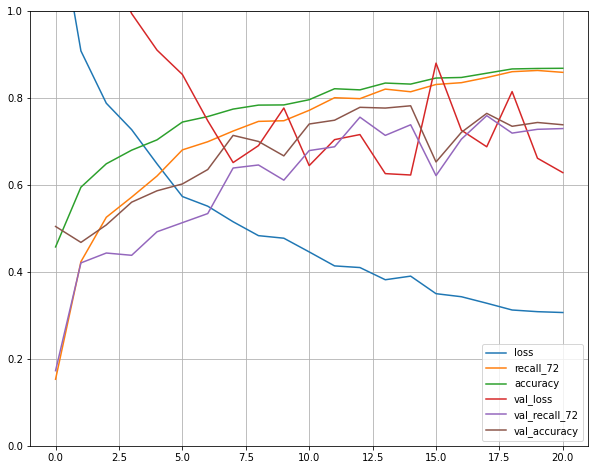

Normalized confusion matrix
[[0.21       0.51       0.24       0.04      ]
 [0.02608696 0.95652174 0.0173913  0.        ]
 [0.08571429 0.14285714 0.77142857 0.        ]
 [0.14864865 0.21621622 0.21621622 0.41891892]]


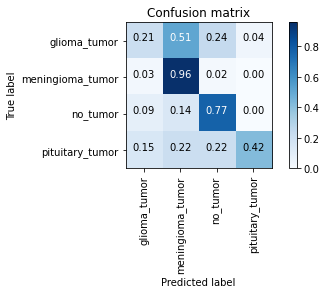

In [263]:
history_baseline_df = pd.DataFrame(history_bright.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = model_bright.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

Bellow average scores when compared to the previous models.  The experimental CNN with the bright dataset was the least overfitt when compared to the other two datasets.

### Using Lime to determine class specific features

I wanted to see inside the black box of the modeling process and understand what features in the images the model is using to predict the specific classes.  With Lime I can see the weighted super pixels generated by the model and observer what segmants of the image are the key classifying features.  

Below I use the alex_bright model which had my best obverall predictions to predict on some randomly selected images for glioma and no tumor classes.  My goal was to find correctly classified images for these two classes and identify how the model is predicting the class.  

In [373]:
#save the limeimage explainer as a variable
explainer = lime_image.LimeImageExplainer(verbose=1)

In [438]:
# select images from glioma and no tumor datasets and predict the labels with alex_bright model

%%time

explanation = explainer.explain_instance(glioma_images[20].astype('double'), 
                                         alex_bright.predict, top_labels=5, hide_color=0, num_samples=1000)

no_tum_explanation = explainer.explain_instance(no_tumor_images[7].astype('double'), 
                                                alex_bright.predict, top_labels=5, hide_color=0, num_samples=1000)


Intercept 0.0007635206810127971
Prediction_local [0.00321932]
Right: 4.775756e-06
Intercept 1.048823149068656
Prediction_local [0.07952]
Right: 7.66932e-06
Intercept -0.03320927958831954
Prediction_local [0.20205828]
Right: 0.05392006
Intercept -0.01637739660918658
Prediction_local [0.71520241]
Right: 0.9460676



Intercept 0.0007267002354293495
Prediction_local [0.00397387]
Right: 0.00023093166
Intercept 0.3811292208020702
Prediction_local [0.13759896]
Right: 0.0033038654
Intercept 0.10850025829616297
Prediction_local [0.3634867]
Right: 0.40593523
Intercept 0.5096438217662862
Prediction_local [0.49494046]
Right: 0.59053004
CPU times: user 1min 34s, sys: 11.1 s, total: 1min 45s
Wall time: 25.6 s


Here I print the top label prediction to make sure the image was predicted correctly.  0 is glioma and 2 is no tumor.  These images where predicted correctly.

In [439]:
#Print the top label prediction
print(explanation.top_labels[0])

print(no_tum_explanation.top_labels[0])


0
2


Text(0.5, 1.0, 'glioma Lime explanation ')

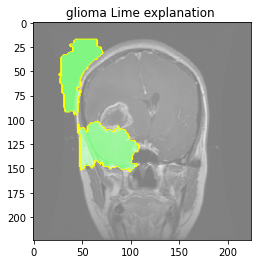

In [440]:
#print colored lime superpixel
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, num_features=10, hide_rest=False,min_weight=.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('glioma Lime explanation ')


In the image above, we can see two colored in lime superpixels which demonstrate the top prediction weights.  It seems that the model does not predict on the obvious tumor in the image but rather on the assymetry of of the brain.  I am unsure why the black background is also being used as a key classification feature for this glioma image.  

Text(0.5, 1.0, 'no tumor Lime explanation ')

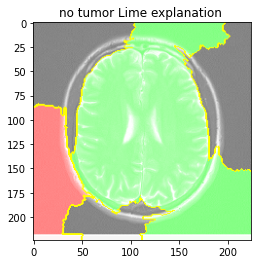

In [437]:
#Lime colored super pixel no tumor

temp1, mask1 = no_tum_explanation.get_image_and_mask(no_tum_explanation.top_labels[0], 
                              
                                                     positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))
plt.title('no tumor Lime explanation ')

In the image above, the symetrical nature of the brain for the no tumor image appears to be the major factor in classifying this image for the no tumor class.  

### Lime weight heatmap for glioma class
Using the same glima image from above, I create a heatmap to show the the positive and negative weights of the lime superpixels.  The lower left recion of the brain where there is asymetry again appears to be the biggest factor in classifying this image of a glioma.  

Text(0.5, 1.0, 'glioma lime explination heatmap')

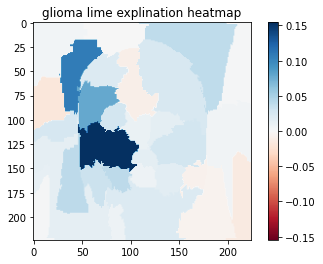

In [441]:

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.title('glioma lime explination heatmap')

***
## Conclusion

The goal of this project was to create a model that could act as a preliminary tumor diagnostic tool. The trained model would greatly increase the accessibility of quality MRI image analysis and reduce the time needed to process MRI images.  In my modeling process the best model was an AlexNet using augmented data that had been brightened in order to highlight the hyperintensity of tumors in the MRI images.  The bright alexnet model had a Recall of 60% and an accuracy of 67.5%.  While other models had better test recall and accuracy metrics, the bright AlexNet had the highest spread of true positive predictions for each class, particularly the pituitary tumor class which had low true positives in many of the other models.  The marginal drop in true positives for the meningioma and no tumor class, may be a direct result from the brightening augmentation.  The augmentation appears to brighten the skull significantly, and this might affect the classifiers ability to detect certain meningiomas since they occur between the skull and the brain.  The increase in no tumor images being classified as meningiomas and vice versa seems to fit this theory.  To address this issue, I will reduce the intensity of the brightness augmentation, and maybe introduce darkened images as well.  

In addition to training models with the bright dataset I also created a class balanced dataset.  The balanced dataset performed poorly on each model and seemed to negatively affect the overall metrics. For the next steps of this study, I will exclude this dataset from any additional CNN architectures I use for classification.   

All models were relatively weak at predicting the glioma tumor class.  By observing a positive classification of a glioma image, I found that the model may be making predictions on the asymmetry of the brain for the glioma tumor class.  For the next steps in the modeling process, I will attempt additional augmentations to exacerbate the asymmetry and aid the model in true positives for the glioma class.

In order to produce a usable diagnostic tool, more work is needed to increase the predictive power of the model.  Additional research into alternative augmentations and CNN structures is needed in order to reduce the false negatives in the model, particularly in the glioma tumor class.  

